In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score


In [2]:
#setting random seed
seed = 42
import random
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
torch.use_deterministic_algorithms(True)

In [3]:
matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
mpl.style.use("default")
mpl.rcParams.update({"figure.constrained_layout.use": True})

sns.set_context("paper") 
sns.set_palette("Set2") 
sns.set_style("whitegrid") 

plt.rc("font", family = "Malgun Gothic")
plt.rcParams["axes.unicode_minus"] = False

In [4]:
# data_prep 에서 train/test split한 pivot table

train_scaled = pd.read_csv("./train_scaled.csv",index_col=0)
test_scaled = pd.read_csv("./test_scaled.csv",index_col=0)
val_scaled = pd.read_csv("./val_scaled.csv",index_col=0)

train = pd.read_csv("./train_orig.csv",index_col=0)
val = pd.read_csv("./val_orig.csv",index_col=0)
test = pd.read_csv("./test_orig.csv",index_col=0)

In [5]:
city_info = ['date_label','geo_label_city']
features_list = []

target_cand = ['Cancer | All Cancer Deaths',
 'Cancer | Colorectal Cancer Deaths', 
 'Cancer | Lung Cancer Deaths', 
 'Cardiovascular Disease | Cardiovascular Disease Deaths',
 'Cardiovascular Disease | Heart Disease Deaths',
 'Deaths | Deaths from All Causes',
 'Deaths | Gun Deaths (Firearms)',
 'Deaths | Injury Deaths',
 'Deaths | Motor Vehicle Deaths',
 'Deaths | Premature Death',
 'Diabetes and Obesity | Diabetes Deaths',
 'Life Expectancy at Birth | Life Expectancy',
 'Mental Health | Suicide',
 'Substance Use | Drug Overdose Deaths']

target_list = target_cand

# 결측치가 너무 많아/불균형해 제외된 column
avoid_list_orig = ['Substance Use | Teen Smoking',
 'Diabetes and Obesity | Teen Obesity',
 'Substance Use | Teen Alcohol',
 'Physical Activity | Teen Computer Time',
 'Physical Activity | Teen Physical Activity',
 'Substance Use | Teen Marijuana',
 'Physical Activity | Teen TV Time',
 'Dietary Quality | Teen Soda',
 'Mental Health | Electronic Bullying',
 'Mental Health | School Bullying',
 'Mental Health | Teen Mental Distress',
 'Mental Health | Teen Suicidal Ideation',
 'Physical Activity | Teen Physical Inactivity',
 'Respiratory Disease | Teen Asthma',
 'School Violence | Fighting in School',
 'School Violence | Weapons in School',
 'Birth Control | Teen Birth Control',
 'Dietary Quality | Teen Breakfast',
 'Physical Activity | Teen Physical Education',
 'Respiratory Infection | COVID-19 Deaths',
 'Respiratory Infection | COVID-19 Vaccination, Adults',
 'Respiratory Infection | COVID-19 Vaccination, Seniors',
 'Births | Prenatal Care',
 'Crime Incidents | Violent Crime',
 'Lead Poisoning | Child Lead Levels 10+ mcg/dL',
 'Lead Poisoning | Child Lead Levels 5+ mcg/dL',
 'Lead Poisoning | Child Lead Testing']

# 일부 target 따라 너무 비슷한 값(ex) All Cancer를 예측할 때 세분화된 Cancer 사망자)
targetspecific_list = {
    'Cancer | All Cancer Deaths': ['Cancer | Breast Cancer Deaths', 'Cancer | Colorectal Cancer Deaths','Cancer | Lung Cancer Deaths','Cancer | Prostate Cancer Deaths', 'Deaths | Deaths from All Causes'],
    'Cancer | Colorectal Cancer Deaths' : [],
    'Cancer | Lung Cancer Deaths' : [],
    'Cardiovascular Disease | Cardiovascular Disease Deaths': [],
    'Cardiovascular Disease | Heart Disease Deaths': [],
    'Deaths | Deaths from All Causes': ['Deaths | Infant Deaths', 'Deaths | Maternal Deaths', 'Deaths | Police Killings', 'Cancer | Breast Cancer Deaths', 'Cancer | Colorectal Cancer Deaths','Cancer | Lung Cancer Deaths','Cancer | Prostate Cancer Deaths'],
    'Deaths | Gun Deaths (Firearms)': [],
    'Deaths | Injury Deaths': [],
    'Deaths | Motor Vehicle Deaths': [],
    'Deaths | Premature Death': [],
    'Diabetes and Obesity | Diabetes Deaths': [],
    'Life Expectancy at Birth | Life Expectancy': [],
    'Mental Health | Suicide': [],
    'Substance Use | Drug Overdose Deaths': []
}

heuristic_list = {
    'Cancer | All Cancer Deaths': [
        'Cancer | Breast Cancer Deaths',
        'Cancer | Prostate Cancer Deaths',
        'Physical Activity | Adult Physical Inactivity',
        'Diabetes and Obesity | Diabetes',
        'Diabetes and Obesity | Teen Obesity',
        'Diabetes and Obesity | Adult Obesity',
        'Dietary Quality | Teen Soda',
        'Substance Use | Adult Binge Drinking',
        'Population | Seniors',
        'Health Insurance | Uninsured, All Ages',
        'Births | Low Birthweight',
        'Births | Prenatal Care',
        'Births | Preterm Births',
        'Births | Teen Births',
        'Income | Poverty in All Ages'
        ],
    'Cancer | Colorectal Cancer Deaths' : [
        'Cancer | Breast Cancer Deaths',
        'Cancer | Prostate Cancer Deaths',
        'Dietary Quality | Teen Breakfast',
        'Dietary Quality | Teen Soda',
        'Diabetes and Obesity | Adult Obesity',
        'Diabetes and Obesity | Teen Obesity',
        'Dietary Quality | Teen Soda',
        'Physical Activity | Teen Physical Inactivity',
        'Population | Seniors',
        'Health Insurance | Uninsured, All Ages',
        'Births | Low Birthweight',
        'Births | Prenatal Care',
        'Births | Preterm Births',
        'Births | Teen Births',
        'Income | Poverty in All Ages'
    ],
    'Cancer | Lung Cancer Deaths' : [
        'Cancer | Breast Cancer Deaths',
        'Cancer | Prostate Cancer Deaths',
        'Substance Use | Adult Smoking',
        'Substance Use | Teen Smoking',
        'Air Pollution | Hazardous Air Quality',
        'Air Pollution | Poor Air Quality',
        'Population | Seniors',
        'Diabetes and Obesity | Diabetes',
        'Health Insurance | Uninsured, All Ages',
        'Births | Low Birthweight',
        'Births | Prenatal Care',
        'Births | Preterm Births',
        'Births | Teen Births',
        'Income | Poverty in All Ages'
    ],
    'Cardiovascular Disease | Cardiovascular Disease Deaths': [
        'Cardiovascular Disease | High Blood Pressure',
        'Diabetes and Obesity | Adult Obesity',
        'Physical Activity | Adult Physical Inactivity',
        'Physical Activity | Teen Physical Activity',
        'Physical Activity | Teen Physical Inactivity',
        'Substance Use | Adult Smoking',
        'Population | Seniors',
        'Births | Low Birthweight',
        'Births | Prenatal Care',
        'Births | Preterm Births',
        'Births | Teen Births',
        'Dietary Quality | Teen Soda',
        'Dietary Quality | Teen Breakfast'
    ],
    'Cardiovascular Disease | Heart Disease Deaths': [
        'Cardiovascular Disease | High Blood Pressure',
        'Diabetes and Obesity | Adult Obesity',
        'Physical Activity | Adult Physical Inactivity',
        'Physical Activity | Teen Physical Activity',
        'Physical Activity | Teen Physical Inactivity',
        'Substance Use | Adult Smoking',
        'Dietary Quality | Teen Soda',
        'Dietary Quality | Teen Breakfast',
        'Population | Seniors',
        'Health Insurance | Uninsured, All Ages',
        'Births | Low Birthweight',
        'Births | Prenatal Care',
        'Births | Preterm Births',
        'Births | Teen Births',
        'Income | Poverty in All Ages'
    ],
    'Deaths | Deaths from All Causes': [],
    'Deaths | Gun Deaths (Firearms)': [
        'Crime Incidents | Homicides',
        'Crime Incidents | Violent Crime',
        'Deaths | Police Killings',
        'Deaths | Racial Disparity in Police Killings',
        'Mental Health | Teen Suicidal Ideation',
        'Mental Health | Adult Mental Distress',
        'Mental Health | School Bullying',
        'Mental Health | Electronic Bullying',
        'Substance Use | Adult Binge Drinking',
        'School Violence | Weapons in School',
        'Education | College Graduates',
        'Education | Preschool Enrollment'
    ],
    'Deaths | Injury Deaths': [
        'Active Transportation | Riding Bike to Work',
        'Active Transportation | Walking to Work',
        'Transportation | Drives Alone to Work',
        'Transportation | Public Transportation Use',
        'Transportation | Lack of Car',
        'Transportation | Longer Driving Commute Time',
        'Population | Seniors',
        'Deaths | Police Killings',
        'Deaths | Racial Disparity in Police Killings',
        'School Violence | Fighting in School',
        'School Violence | Weapons in School',
        'Transportation | Drives Alone to Work',
        'Transportation | Longer Driving Commute Time',
        'Health Insurance | Uninsured, All Ages',
        'Income | Poverty in All Ages'
    ],
    'Deaths | Motor Vehicle Deaths': [
        'Active Transportation | Riding Bike to Work',
        'Active Transportation | Walking to Work',
        'Transportation | Drives Alone to Work',
        'Transportation | Longer Driving Commute Time',
        'Health Insurance | Uninsured, All Ages',
        'Substance Use | Adult Binge Drinking',
        'Transportation | Drives Alone to Work',
        'Transportation | Longer Driving Commute Time'
    ],
    'Deaths | Premature Death': [
        'Cardiovascular Disease | High Blood Pressure',
        'Diabetes and Obesity | Adult Obesity',
        'Physical Activity | Adult Physical Inactivity',
        'Substance Use | Adult Smoking',
        'Mental Health | Adult Mental Distress',
        'Cancer | Breast Cancer Deaths',
        'Cancer | Prostate Cancer Deaths',
        'Deaths | Infant Deaths (영아사망)',
        'Deaths | Maternal Deaths (모성 사망)',
        'Heat and Disasters | Climate-related Disasters',
        'Heat and Disasters | Community Social Vulnerability to Climate Disasters',
        'Heat and Disasters | Longer Summers',
        'Heat and Disasters | Number of Heat Waves',
        'Health Insurance | Uninsured, All Ages',
        'Health Insurance | Uninsured, Child',
        'Income | Poverty in All Ages',
        'Lead Poisoning | Child Lead Levels 10+ mcg/dL',
        'Lead Poisoning | Child Lead Levels 5+ mcg/dL',
        'Lead Poisoning | Child Lead Testing',
        'Lead Poisoning | Housing Lead Risk',
        'Respiratory Infection | COVID-19 Deaths',
        'Respiratory Infection | New Tuberculosis Cases (신규 결핵 환자 수)',
        'Respiratory Infection | Pneumonia or Influenza Deaths (폐렴/ 인플루엔자)',
        'School Violence | Fighting in School',
        'School Violence | Weapons in School',
        'Sexually Transmitted Disease | HIV-Related Deaths',
        'Sexually Transmitted Disease | HIV/AIDS Prevalence',
        'Transportation | Drives Alone to Work',
        'Transportation | Longer Driving Commute Time'
    ],
    'Diabetes and Obesity | Diabetes Deaths': [
        'Diabetes and Obesity | Diabetes',
        'Diabetes and Obesity | Adult Obesity',
        'Cardiovascular Disease | High Blood Pressure',
        'Physical Activity | Adult Physical Inactivity',
        'Physical Activity | Teen Physical Activity',
        'Physical Activity | Teen Physical Inactivity',
        'Dietary Quality | Teen Soda',
        'Dietary Quality | Teen Breakfast',
        'Population | Seniors'
    ],
    'Life Expectancy at Birth | Life Expectancy': [
        'Cancer | Prostate Cancer Deaths',
        'Cancer | Breast Cancer Deaths',
        'Cardiovascular Disease | High Blood Pressure',
        'Diabetes and Obesity | Adult Obesity',
        'Cardiovascular Disease | High Blood Pressure',
        'Income | Per-capita Household Income',
        'Lead Poisoning | Child Lead Levels 10+ mcg/dL',
        'Lead Poisoning | Child Lead Levels 5+ mcg/dL',
        'Lead Poisoning | Child Lead Testing',
        'Lead Poisoning | Housing Lead Risk',
        'Substance Use | Teen Alcohol',
        'Substance Use | Teen Marijuana',
        'Substance Use | Teen Smoking'
    ],
    'Mental Health | Suicide': [
        'Mental Health | Adult Mental Distress',
        'Mental Health | Teen Suicidal Ideation',
        'Mental Health | Electronic Bullying',
        'Mental Health | School Bullying',
        'Mental Health | Teen Mental Distress',
        'Births | Teen Births',
        'Substance Use | Adult Binge Drinking',
        'Substance Use | Adult Smoking',
        'Crime Incidents | Homicides',
        'Crime Incidents | Violent Crime',
        'Deaths | Infant Deaths (영아사망)',
        'Deaths | Maternal Deaths (모성 사망)',
        'Cardiovascular Disease | High Blood Pressure',
        'Cancer | Breast Cancer Deaths',
        'Cancer | Prostate Cancer Deaths',
        'Income | Poverty in All Ages',
        'Housing | Homeless, Children',
        'Housing | Homeless, Total',
        'Housing | Owner Occupied Housing',
        'Housing | Vacant Housing Units',
        'Housing | Vacant Housing and Homelessness',
        'Income Inequality | Household Income Inequality (소득 불평등)',
        'Income Inequality | Income Inequality',
        'Income | Households with Higher-Incomes',
        'Income | Per-capita Household Income (인당/가구당 소득)',
        'Income | Poverty and Near Poverty in All Ages',
        'Income | Poverty in All Ages',
        'Income | Poverty in Children',
        'Income-related | Excessive Housing Cost',
        'Income-related | Public Assistance',
        'Income-related | Service Workers',
        'Income-related | Unemployment',
        'School Violence | Fighting in School',
        'Substance Use | Adult Binge Drinking',
        'Substance Use | Opioid Overdose Deaths',
        'Substance Use | Teen Alcohol',
        'Substance Use | Teen Marijuana',
        'Substance Use | Teen Smoking'
    ],
    'Substance Use | Drug Overdose Deaths': [
        'Substance Use | Opioid Overdose Deaths',
        'Substance Use | Teen Marijuana (대마초)',
        'Substance Use | Teen Alcohol',
        'Mental Health | Teen Suicidal Ideation',
        'Mental Health | Adult Mental Distress',
        'Mental Health | Electronic Bullying',
        'Mental Health | School Bullying',
        'Mental Health | Teen Mental Distress',
        'Health Insurance | Uninsured, All Ages',
        'Cancer | Breast Cancer Deaths',
        'Cancer | Prostate Cancer Deaths',
        'Income | Poverty in All Ages',
        'Housing | Homeless, Children',
        'Housing | Homeless, Total',
        'Housing | Owner Occupied Housing',
        'Housing | Vacant Housing Units',
        'Housing | Vacant Housing and Homelessness',
        'Income Inequality | Household Income Inequality (소득 불평등)',
        'Income Inequality | Income Inequality',
        'Income | Households with Higher-Incomes',
        'Income | Per-capita Household Income (인당/가구당 소득)',
        'Income | Poverty and Near Poverty in All Ages',
        'Income | Poverty in All Ages',
        'Income | Poverty in Children',
        'Income-related | Excessive Housing Cost',
        'Income-related | Public Assistance',
        'Income-related | Service Workers',
        'Income-related | Unemployment',
        'Lead Poisoning | Child Lead Levels 10+ mcg/dL',
        'Lead Poisoning | Child Lead Levels 5+ mcg/dL',
        'Lead Poisoning | Child Lead Testing (아동 납 검사)',
        'Lead Poisoning | Housing Lead Risk (주택 내 납 노출 위험)',
        'Substance Use | Opioid Overdose Deaths',
        'Substance Use | Teen Alcohol',
        'Substance Use | Teen Marijuana',
        'Substance Use | Teen Smoking'
    ]
}

# avoid_list += targetspecific_list

# x_train = train_scaled.loc[:,~(train_scaled.columns.isin(avoid_list) | train_scaled.columns.isin(target_list) | train_scaled.columns.isin(city_info))]#features_list]
# y_train = train[target_list]

# x_val = val_scaled.loc[:,~(val_scaled.columns.isin(avoid_list) | val_scaled.columns.isin(target_list) | val_scaled.columns.isin(city_info))]#features_list]
# y_val = val[target_list]

# x_test = test_scaled.loc[:,~(test_scaled.columns.isin(avoid_list) | test_scaled.columns.isin(target_list) | test_scaled.columns.isin(city_info))]#features_list]
# y_test = test[target_list]

In [6]:
# #heuristic하게 고른 항목들로만 하면 얼마나 나을까?
# city_info = ['date_label','geo_label_city']
# features_list = []

# target_list = ['Cancer | All Cancer Deaths']

# avoid_list = ['Cancer | Breast Cancer Deaths', 'Cancer | Colorectal Cancer Deaths','Cancer | Lung Cancer Deaths','Cancer | Prostate Cancer Deaths', 'Deaths | Deaths from All Causes']


# heuristic_list = ["Cancer | Breast Cancer Deaths",
# "Cancer | Prostate Cancer Deaths",
# "Physical Activity | Adult Physical Inactivity",
# "Diabetes and Obesity | Diabetes",
# "Diabetes and Obesity | Teen Obesity",
# "Diabetes and Obesity | Adult Obesity",
# "Dietary Quality | Teen Soda",
# "Population | Seniors",
# "Health Insurance | Uninsured, All Ages",
# "Births | Low Birthweight",
# "Births | Prenatal Care",
# "Births | Preterm Births",
# "Births | Teen Births",
# "Income | Poverty in All Ages"]

# x_train = x_train = train_scaled.loc[:,train_scaled.columns.isin(heuristic_list) & ~(train_scaled.columns.isin(avoid_list))]#features_list]
# y_train = train[target_list]

# x_val = val_scaled.loc[:,val_scaled.columns.isin(heuristic_list) & ~(val_scaled.columns.isin(avoid_list))]#features_list]
# y_val = val[target_list]

# x_test = test_scaled.loc[:,test_scaled.columns.isin(heuristic_list) & ~(test_scaled.columns.isin(avoid_list))]#features_list]
# y_test = test[target_list]

In [7]:
class CityData(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.Tensor(x_data.values)
        self.y_data = torch.Tensor(y_data.values)
    
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return len(self.y_data)

In [55]:
class MLPRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(89,50)
        self.fc2 = nn.Linear(50,30)
        self.fc3 = nn.Linear(30,10)
        self.fc4 = nn.Linear(10,1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0)
    
    def forward(self, x):
        x = self.dropout(self.relu(self.fc1(x)))
        print('fc1: ',x)
        print(self.fc1.weight)
        x = self.dropout(self.relu(self.fc2(x)))
        print('fc2: ',x)
        print(self.fc2.weight)
        x = self.dropout(self.relu(self.fc3(x)))
        print('fc3: ',x)
        print(self.fc3.weight)
        x = self.fc4(x)
        print('fc4: ',x)
        print(self.fc4.weight)

        return x


In [56]:
# !pip install livelossplot
# !conda install tqdm -y

In [57]:
from livelossplot.outputs import MatplotlibPlot
from livelossplot import PlotLosses
from tqdm import tqdm, trange



def train_model(model, train_loader, optimizer, criterion, val_loader=None, n_epoch=30,  plotpath='./lossplot_mlp.png'):

    answer = torch.tensor([])
    prediction = torch.tensor([])

    plotlosses = PlotLosses(outputs=[MatplotlibPlot(figpath = plotpath)])
    # plotlosses = PlotLosses()

    for epoch in trange(n_epoch):
        model.train()
        answer = torch.tensor([])
        prediction = torch.tensor([])
        for idx, data in enumerate(train_loader):
            x, y = data
            optimizer.zero_grad()
            yhat = model(x)

            loss = criterion(yhat, y)
            loss.backward()
            optimizer.step()


            prediction = torch.cat((prediction,yhat),0)
            answer = torch.cat((answer,y),0)
        
        prediction = prediction.detach().numpy()
        answer = answer.numpy()
        train_loss = mean_squared_error(prediction,answer)
        train_r2 = r2_score(prediction,answer)

        if val_loader:
            model.eval()
            answer = torch.tensor([])
            prediction = torch.tensor([])
            with torch.no_grad():
                for idx, data in enumerate(val_loader):
                    x, y = data
                    yhat = model(x)

                    prediction = torch.cat((prediction,yhat),0)
                    answer = torch.cat((answer,y),0)
            prediction = prediction.detach().numpy()
            answer = answer.numpy()
            val_loss = mean_squared_error(prediction, answer)
            val_r2 = r2_score(prediction,answer)

            plotlosses.update({
                'loss': train_loss,
                'val_loss': val_loss,
                'r2' : train_r2,
                'val_r2' : val_r2
            })
        else:
            plotlosses.update({
                'loss': train_loss,
                'r2' : train_r2
            })
        plotlosses.send()

    return model


In [58]:
def evaluate_model(model,test_loader):
    answer = torch.tensor([])
    prediction = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for idx, data in enumerate(test_loader):
            x, y = data
            # print(x)
            yhat = model(x)

            prediction = torch.cat((prediction,yhat),0)
            answer = torch.cat((answer,y),0)
    prediction = prediction.detach().numpy()
    answer = answer.numpy()
    test_mse = mean_squared_error(prediction, answer)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(prediction, answer)

    return {'mse': test_mse, 'rmse': test_rmse, 'r2': test_r2}

In [64]:
#Hyperparameter
fill_na = True
batch_size = 4
n_epoch = 100
heuristic = False

In [65]:
# target_list = ['Cancer | All Cancer Deaths']

result_dict = dict()

for target in target_list:

    print(f'target: {target}')
    avoid_list = avoid_list_orig
    avoid_list += targetspecific_list[target]

    if heuristic:
        x_train = x_train = train_scaled.loc[:,train_scaled.columns.isin(heuristic_list) & ~(train_scaled.columns.isin(avoid_list))]#features_list]
        y_train = train[target_list]

        x_val = val_scaled.loc[:,val_scaled.columns.isin(heuristic_list) & ~(val_scaled.columns.isin(avoid_list))]#features_list]
        y_val = val[target_list]

        x_test = test_scaled.loc[:,test_scaled.columns.isin(heuristic_list) & ~(test_scaled.columns.isin(avoid_list))]#features_list]
        y_test = test[target_list]

    x_train = train_scaled.loc[:,~(train_scaled.columns.isin(avoid_list) | train_scaled.columns.isin(target_cand) | train_scaled.columns.isin(city_info))]#features_list]
    y_train = train[target_list]

    x_val = val_scaled.loc[:,~(val_scaled.columns.isin(avoid_list) | val_scaled.columns.isin(target_cand) | val_scaled.columns.isin(city_info))]#features_list]
    y_val = val[target_list]

    x_test = test_scaled.loc[:,~(test_scaled.columns.isin(avoid_list) | test_scaled.columns.isin(target_cand) | test_scaled.columns.isin(city_info))]#features_list]
    y_test = test[target_list]

    if fill_na:
        for col in x_train.columns:
            x_train[col] = x_train[col].fillna(x_train[col].median())
            x_val[col] = x_val[col].fillna(x_train[col].median())
            x_test[col] = x_test[col].fillna(x_train[col].median())


    train_dataset = CityData(x_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_dataset = CityData(x_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    test_dataset = CityData(x_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = MLPRegressor()
    criterion = nn.MSELoss()

    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
    # optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3, weight_decay  = 0.9)

    input_shape = len(x_train.columns)
    model.fc1 = nn.Linear(input_shape,50)

    eval_model = train_model(model,train_loader, optimizer, criterion, val_loader=val_loader, n_epoch=n_epoch,plotpath='./lossplot_mlp.png')

    train_result = evaluate_model(eval_model, train_loader)
    eval_result = evaluate_model(eval_model,test_loader)

    result_dict[target] = {'train': train_result, 'test': eval_result}
    

C:\Users\Post Scriptum\AppData\Local\Temp\ipykernel_27784\1021937802.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train[col] = x_train[col].fillna(x_train[col].median())
C:\Users\Post Scriptum\AppData\Local\Temp\ipykernel_27784\1021937802.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val[col] = x_val[col].fillna(x_train[col].median())
C:\Users\Post Scriptum\AppData\Local\Temp\ipykernel_27784\1021937802.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

target: Cancer | All Cancer Deaths


  0%|          | 0/100 [00:00<?, ?it/s]

fc1:  tensor([[0.0000, 0.2195, 0.0000, 0.1073, 0.0000, 0.0000, 0.0684, 0.0000, 0.0000,
         0.2313, 0.0153, 0.0987, 0.4856, 0.0824, 0.1971, 0.0000, 0.1777, 0.0000,
         0.1986, 0.4128, 0.1682, 0.0726, 0.0000, 0.0000, 0.0000, 0.2540, 0.0000,
         0.0000, 0.0000, 0.1425, 0.2015, 0.0000, 0.1701, 0.0000, 0.1044, 0.0000,
         0.0311, 0.0000, 0.0000, 0.2706, 0.0790, 0.0000, 0.0000, 0.0433, 0.0000,
         0.0500, 0.0849, 0.0000, 0.5166, 0.0000],
        [0.0499, 0.2379, 0.0000, 0.1263, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.1194, 0.1580, 0.0000, 0.3855, 0.1188, 0.0797, 0.0440, 0.2763, 0.0000,
         0.1645, 0.3518, 0.3539, 0.2088, 0.0000, 0.0000, 0.0000, 0.1289, 0.0000,
         0.0000, 0.0000, 0.1639, 0.0000, 0.0000, 0.1484, 0.0000, 0.3311, 0.0000,
         0.1611, 0.0000, 0.0000, 0.1990, 0.1851, 0.0030, 0.0000, 0.0320, 0.0000,
         0.0000, 0.1074, 0.0000, 0.2705, 0.0000],
        [0.0000, 0.2493, 0.1341, 0.1393, 0.0000, 0.0000, 0.3244, 0.0000, 0.0354,
   

t:\miniconda3\envs\wassup_pr1\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4, 14])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


fc1:  tensor([[0.0153, 0.2041, 0.0000, 0.1706, 0.0000, 0.0000, 0.0488, 0.0000, 0.0000,
         0.1120, 0.1145, 0.0664, 0.4959, 0.0670, 0.1653, 0.0000, 0.2487, 0.0000,
         0.1818, 0.3380, 0.0751, 0.0720, 0.0000, 0.0000, 0.0618, 0.1512, 0.0000,
         0.0000, 0.0000, 0.1755, 0.1561, 0.0085, 0.1502, 0.0000, 0.1022, 0.0000,
         0.0634, 0.0000, 0.0000, 0.2665, 0.0884, 0.0731, 0.0000, 0.0113, 0.0217,
         0.0695, 0.0422, 0.0000, 0.5131, 0.0000],
        [0.0000, 0.3767, 0.0000, 0.0000, 0.0000, 0.2141, 0.0678, 0.0000, 0.0314,
         0.1122, 0.1626, 0.0000, 0.6268, 0.0165, 0.5181, 0.1839, 0.3209, 0.0000,
         0.2846, 0.0669, 0.5705, 0.0000, 0.0000, 0.0000, 0.0437, 0.1272, 0.0523,
         0.0689, 0.0000, 0.4932, 0.0000, 0.0000, 0.1798, 0.0000, 0.0000, 0.0000,
         0.4884, 0.0000, 0.0000, 0.1624, 0.0000, 0.2268, 0.0000, 0.0811, 0.0000,
         0.4598, 0.0000, 0.0000, 0.5786, 0.0000],
        [0.0000, 0.2192, 0.0142, 0.0000, 0.0279, 0.0000, 0.0000, 0.1475, 0.0000,
   

  0%|          | 0/100 [00:00<?, ?it/s]


ValueError: Input contains NaN.

In [ ]:
result_dict

{'Cancer | All Cancer Deaths': {'train': {'mse': 95.095276,
   'rmse': 9.75168,
   'r2': 0.86077901955576},
  'test': {'mse': 731.32654, 'rmse': 27.043049, 'r2': -0.8259989095644802}}}

## Bagging

t:\miniconda3\envs\wassup_pr1\lib\site-packages\livelossplot\outputs\matplotlib_plot.py:103: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


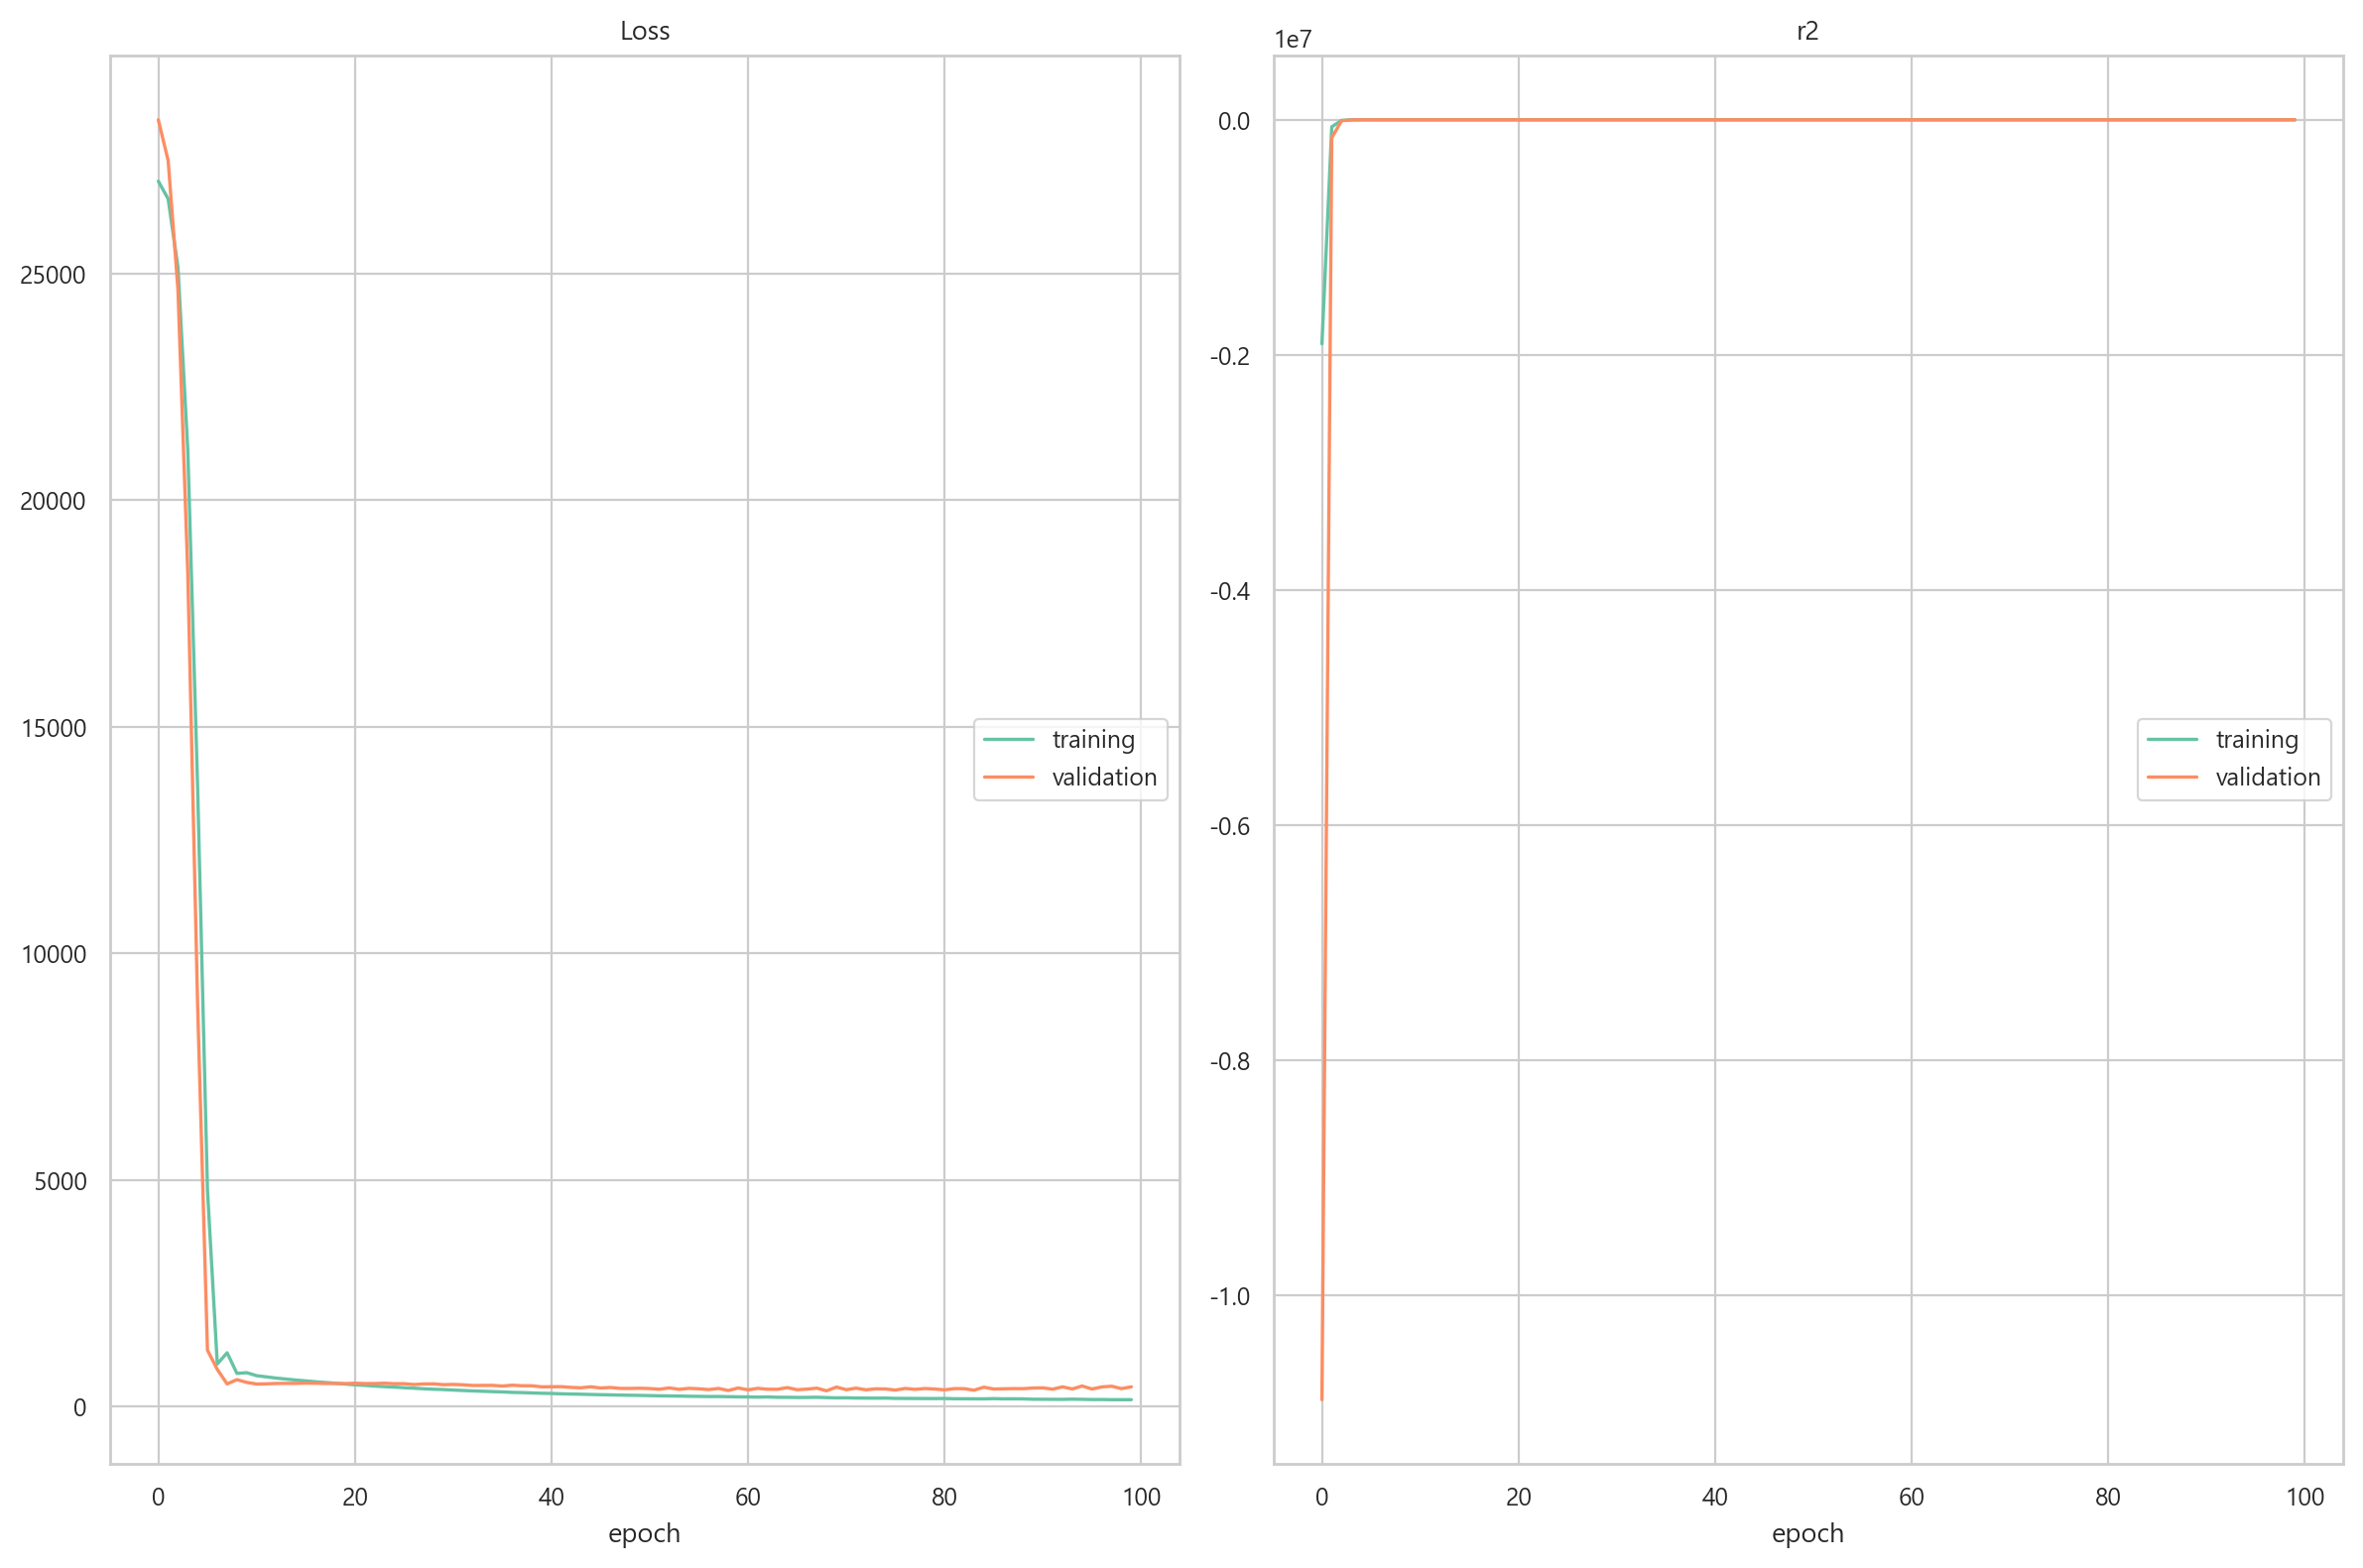

100%|██████████| 100/100 [01:18<00:00,  1.27it/s]


In [95]:
from livelossplot.outputs import MatplotlibPlot
from livelossplot import PlotLosses
from tqdm import tqdm, trange

bagging = 5
best_metric = 99999

for bag_idx in range(bagging):
    bagging_idx = np.random.choice(x_train.index,int(len(x_train) * 0.9))
    bag_train_dataset = CityData(x_train.iloc[bagging_idx,:], y_train.iloc[bagging_idx,:])
    bag_train_loader = DataLoader(bag_train_dataset, batch_size=32, shuffle=True)

    model = MLPRegressor()
    criterion = nn.MSELoss()

    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
    # optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3, weight_decay  = 0.9)

    input_shape = len(x_train.columns)
    model.fc1 = nn.Linear(input_shape,50)

    train_loss = list()
    n_epoch = 100

    plotlosses = PlotLosses(outputs=[MatplotlibPlot(figpath =f"lossplot_mlp_bag{bag_idx}.png")])
    # plotlosses = PlotLosses()

    for epoch in trange(n_epoch):
        model.train()
        answer = torch.tensor([])
        prediction = torch.tensor([])
        for idx, data in enumerate(bag_train_loader):
            x, y = data

            optimizer.zero_grad()
            yhat = model(x)

            loss = criterion(yhat, y)
            loss.backward()
            optimizer.step()


            prediction = torch.cat((prediction,yhat),0)
            answer = torch.cat((answer,y),0)
        
        prediction = prediction.detach().numpy()
        answer = answer.numpy()
        train_loss = mean_squared_error(prediction,answer)
        train_r2 = r2_score(prediction,answer)

        model.eval()
        answer = torch.tensor([])
        prediction = torch.tensor([])
        with torch.no_grad():
            for idx, data in enumerate(val_loader):
                x, y = data
                yhat = model(x)

                prediction = torch.cat((prediction,yhat),0)
                answer = torch.cat((answer,y),0)
        prediction = prediction.detach().numpy()
        answer = answer.numpy()
        val_loss = mean_squared_error(prediction, answer)
        val_r2 = r2_score(prediction,answer)

        path = f'./{bag_idx}_best.pt'
        if best_metric > val_loss:
            best_metric = val_loss
            torch.save(model.state_dict(), path)
            print(best_metric, 'Saving to', path)

        plotlosses.update({
            'loss': train_loss,
            'val_loss': val_loss,
            'r2' : train_r2,
            'val_r2' : val_r2
        })
        plotlosses.send()


In [96]:
# models = []
# for i in range(bagging):
#     try:
#         models.append(MLPRegressor().load_state_dict(torch.load(f'./{i}_best.pt')))
#     except:
#         continue

model_0 = MLPRegressor()
model_0.load_state_dict(torch.load(f'./0_best.pt'))

model_1 = MLPRegressor()
model_1.load_state_dict(torch.load(f'./1_best.pt'))

model_2 = MLPRegressor()
model_2.load_state_dict(torch.load(f'./2_best.pt'))

model_4 = MLPRegressor()
model_4.load_state_dict(torch.load(f'./4_best.pt'))

models = [model_0,model_1,model_2,model_4]

answer = torch.tensor([])
prediction = torch.tensor([])
with torch.no_grad():
    for idx, data in enumerate(test_loader):
        yhats = list()
        x, y = data
        for model in models:
            model.eval()
            yhats.append(model(x))
        yhat = torch.mean(torch.stack(yhats,dim=1),dim=1)
        # print(x)

        prediction = torch.cat((prediction,yhat),0)
        answer = torch.cat((answer,y),0)
prediction = prediction.detach().numpy()
answer = answer.numpy()
test_mse = mean_squared_error(prediction, answer)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(prediction, answer)

print(test_mse)
print(test_rmse)
print(test_r2)

651.25287
25.519657
-1.368276870440703


In [97]:
for model in models:
    model.eval()
    answer = torch.tensor([])
    prediction = torch.tensor([])

    with torch.no_grad():
        for idx, data in enumerate(test_loader):
            yhats = list()
            x, y = data
            yhat = model(x)
            # print(x)

            prediction = torch.cat((prediction,yhat),0)
            answer = torch.cat((answer,y),0)
    prediction = prediction.detach().numpy()
    answer = answer.numpy()
    test_mse = mean_squared_error(prediction, answer)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(prediction, answer)

    print(test_mse)
    print(test_rmse)
    print(test_r2)

592.2932
24.337074
-1.1864823261253736
526.39185
22.943232
-0.896362043752936
1548.452
39.350376
-1.4709321930470738
463.37128
21.52606
-0.11640853330002732
